## Word Embeddings through Hellinger PCA

### Library import

In [23]:
from __future__ import division
from math import log,sqrt
import operator

# Hack to shut up deprecation warning wrt something in the stemmer
import sys, importlib
sys.modules['sklearn.externals.six'] = importlib.import_module('six')

from nltk.stem import *
from nltk.stem.porter import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from load_map import *

## Helper functions definition

In [24]:
def read_counts(filename, wids):
    '''Reads the counts from file. It returns counts for all words, but to
    save memory it only returns cooccurrence counts for the words
    whose ids are listed in wids.

    :type filename: string
    :type wids: list
    :param filename: where to read info from
    :param wids: a list of word ids
    :returns: occurence counts, cooccurence counts, and tot number of observations
    '''
    o_counts = {} # Occurence counts
    co_counts = {} # Cooccurence counts
    fp = open(filename)
    N = float(next(fp))
    for line in fp:
        line = line.strip().split("\t")
        wid0 = int(line[0])
        o_counts[wid0] = int(line[1])
        if(wid0 in wids):
            co_counts[wid0] = dict([int(y) for y in x.split(" ")] for x in line[2:])

    return (o_counts, co_counts, N)

def get_o_counts(filename):
    '''Reads the counts from file. It returns counts for all words, but to
    save memory it only returns cooccurrence counts for the words
    whose ids are listed in wids.

    :type filename: string
    :type wids: list
    :param filename: where to read info from
    :param wids: a list of word ids
    :returns: occurence counts, cooccurence counts, and tot number of observations
    '''
    o_counts = {} # Occurence counts
    co_counts = {} # Cooccurence counts
    fp = open(filename)
    N = float(next(fp))
    for line in fp:
        line = line.strip().split("\t")
        wid0 = int(line[0])
        o_counts[wid0] = int(line[1])

    return o_counts


def print_sorted_pairs(similarities, o_counts, first=0, last=100):
    '''Sorts the pairs of words by their similarity scores and prints
    out the sorted list from index first to last, along with the
    counts of each word in each pair.

    :type similarities: dict 
    :type o_counts: dict
    :type first: int
    :type last: int
    :param similarities: the word id pairs (keys) with similarity scores (values)
    :param o_counts: the counts of each word id
    :param first: index to start printing from
    :param last: index to stop printing
    :return: none
    '''
    if first < 0: last = len(similarities)
    for pair in sorted(similarities.keys(), key=lambda x: similarities[x], reverse = True)[first:last]:
        word_pair = (wid2word[pair[0]], wid2word[pair[1]])
        print("{:.2f}\t{:30}\t{}\t{}".format(similarities[pair],str(word_pair),
                                             o_counts[pair[0]],o_counts[pair[1]]))

def freq_v_sim(sims):
    xs = []
    ys = []
    for pair in sims.items():
        ys.append(pair[1])
        c0 = o_counts[pair[0][0]]
        c1 = o_counts[pair[0][1]]
        xs.append(min(c0,c1))
    plt.clf() # clear previous plots (if any)
    plt.xscale('log') #set x axis to log scale. Must do *before* creating plot
    plt.plot(xs, ys, 'k.') # create the scatter plot
    plt.xlabel('Min Freq')
    plt.ylabel('Similarity')
    print("Freq vs Similarity Spearman correlation = {:.2f}".format(spearmanr(xs,ys)[0]))
    #  plt.show() #display the set of plots

def make_pairs(items):
    '''Takes a list of items and creates a list of the unique pairs
    with each pair sorted, so that if (a, b) is a pair, (b, a) is not
    also included. Self-pairs (a, a) are also not included.

    :type items: list
    :param items: the list to pair up
    :return: list of pairs

    '''
    return [(x, y) for x in items for y in items if x < y]

## PMI Calculations

In [25]:
STEMMER = PorterStemmer()

# helper function to get the count of a word (string)
def w_count(word):
  return o_counts[word2wid[word]]

def tw_stemmer(word):
  '''Stems the word using Porter stemmer, unless it is a 
  username (starts with @).  If so, returns the word unchanged.

  :type word: str
  :param word: the word to be stemmed
  :rtype: str
  :return: the stemmed word

  '''
  if word[0] == '@': #don't stem these
    return word
  else:
    return STEMMER.stem(word)

def PMI(c_xy, c_x, c_y, N):
  '''Compute the pointwise mutual information using cooccurrence counts.

  :type c_xy: int 
  :type c_x: int 
  :type c_y: int 
  :type N: int
  :param c_xy: coocurrence count of x and y
  :param c_x: occurrence count of x
  :param c_y: occurrence count of y
  :param N: total observation count
  :rtype: float
  :return: the pmi value

  '''
  return log(N*c_xy / (c_x * c_y), 2) 

#Do a simple error check using value computed by hand
if(PMI(2,4,3,12) != 1): # these numbers are from our y,z example
    print("Warning: PMI is incorrectly defined")
else:
    print("PMI check passed")

PMI check passed


## TF-IDF considering each word as a document

In [26]:
def tf_idf(o_counts, co_counts):
    N = len(o_counts)
    tf_idf_vect = {}

    for wid in co_counts.keys():
        curr_vect = co_counts[wid]
        df = len(curr_vect)
        idf = np.log10(N/df)
        tfidf_vec = [np.log10(value)*idf for value in curr_vect.values()]
        tf_idf_vect[wid] = np.array(tfidf_vec)
    
    return tf_idf_vect

def tf_dif_cosine(vec0, vec1):
    max_l = max(len(vec0), len(vec1))
    
    vec0 = np.concatenate((vec0, np.zeros(max_l-len(vec0))), axis=None).reshape(max_l,1)
    vec1 = np.concatenate((vec1, np.zeros(max_l-len(vec1))), axis=None).reshape(max_l,1)
    
    return np.dot(vec0.T, vec1)/(np.linalg.norm(vec0)*np.linalg.norm(vec1))

In [27]:
test_words = ["cat", "dog", "mouse", "computer","@justinbieber"]
stemmed_words = [tw_stemmer(w) for w in test_words]
all_wids = set([word2wid[x] for x in stemmed_words]) #stemming might create duplicates; remove them


#print(word2wid.keys())
# you could choose to just select some pairs and add them by hand instead
# but here we automatically create all pairs 
wid_pairs = make_pairs(all_wids)


#read in the count information (same as in lab)
(o_counts, co_counts, N) = read_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts", all_wids)

#make the word vectors
vectors = tf_idf(o_counts, co_counts)

# compute cosine similarites for all pairs we consider
c_sims = {(wid2word[wid0],wid2word[wid1]): tf_dif_cosine(vectors[wid0],vectors[wid1])[0][0] for (wid0,wid1) in wid_pairs}


## Similarity Measures

In [28]:
def cos_sim(v0,v1):
    '''Compute the cosine similarity between two sparse vectors.

    :type v0: dict
    :type v1: dict
    :param v0: first sparse vector
    :param v1: second sparse vector
    :rtype: float
    :return: cosine between v0 and v1
    '''
    # We recommend that you store the sparse vectors as dictionaries
    # with keys giving the indices of the non-zero entries, and values
    # giving the values at those dimensions.

    #You will need to replace with the real function
    if type(v0) == dict:
        v0_mod2 = np.sum(np.square(list(v0.values())))
        v1_mod2 = np.sum(np.square(list(v1.values())))
        
        v0_dot_v1 = 0
        for v0_key, v0_value in v0.items():
            try: 
                  v0_dot_v1 += v1[v0_key]*v0_value
            except:
                  pass

        return v0_dot_v1/(v0_mod2 * v1_mod2)**0.5
    
    else:
        v0_mod2 = np.sum(np.square(v0))
        v1_mod2 = np.sum(np.square(v1))
        
        print(np.dot(v1, v0).shape)
        print("This should be a number:", (np.linalg.norm(v0_mod2) * np.linalg.norm(v1_mod2)))
                


## Word embedding methods

In [29]:
# PPMI Vector Embeddings
def create_ppmi_vectors(wids, o_counts, co_counts, tot_count):
    '''Creates context vectors for the words in wids, using PPMI.
    These should be sparse vectors.

    :type wids: list of int
    :type o_counts: dict
    :type co_counts: dict of dict
    :type tot_count: int
    :param wids: the ids of the words to make vectors for
    :param o_counts: the counts of each word (indexed by id)
    :param co_counts: the cooccurrence counts of each word pair (indexed by ids)
    :param tot_count: the total number of observations
    :rtype: dict
    :return: the context vectors, indexed by word id
    '''
    vectors = {}
    for wid0 in wids:
      vectors[wid0] = {}
      for wid1 in co_counts[wid0].keys():
        PMI_value = PMI(co_counts[wid0][wid1], o_counts[wid0], o_counts[wid1], tot_count)
        if PMI_value > 0:
          vectors[wid0][wid1] = PMI_value
    return vectors

# Hellinger PCA Vecotr EMbeddings
def get_h_sq_matrix(word_limit):
    o_counts = get_o_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts")
    
    sorted_o_counts = dict(sorted(o_counts.items(), key=operator.itemgetter(1),reverse=True))
    
    wids = list(sorted_o_counts.keys())[:word_limit]
    
    (_, test_co_counts, test_N) = read_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts", wids)
    
    square_matrix =[]
    for wid in wids:
        cur_row = []
        current_vec = test_co_counts[wid]
        for wid in wids:
            try:
                cur_row.append(current_vec[wid])
            except:
                cur_row.append(0)

        square_matrix.append(np.array(cur_row)/sum(cur_row))

    square_matrix = np.array(square_matrix)
    
    return np.sqrt(square_matrix)/np.sqrt(2)

def h_PCA_data(word_limit, K_components):
    h_matrix = get_h_sq_matrix(word_limit)
    Gb_array_size = (h_matrix.size*h_matrix.itemsize)/(1024**3)
    
    print("H Matrix size:", Gb_array_size)
    
    # PCA via SVD, for NxD matrix X
    X = h_matrix
    K = K_components
    x_bar = np.mean(X, 0)
    [U, vecS, VT] = np.linalg.svd(X - x_bar, 0) # Apply SVD to centred data
    U = U[:, :K] # NxK "datapoints" transformed into K-dims
    
    return U

## Test environment

In [30]:
test_words = ["cat", "dog", "mouse", "computer","@justinbieber", "love", "good", "bad"]
stemmed_words = [tw_stemmer(w) for w in test_words]
all_wids = set([word2wid[x] for x in stemmed_words]) #stemming might create duplicates; remove them


#print(word2wid.keys())
# you could choose to just select some pairs and add them by hand instead
# but here we automatically create all pairs 
wid_pairs = make_pairs(all_wids)

#all_wids = list(get_o_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts").keys())[:50000]

#read in the count information (same as in lab)
print("Extracting counts")
(o_counts, co_counts, N) = read_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts", all_wids)

#make the word vectors
print("Calucalating Vectors")
vectors = create_ppmi_vectors(all_wids, o_counts, co_counts, N)

# compute cosine similarites for all pairs we consider
c_sims = {(wid0,wid1): cos_sim(vectors[wid0],vectors[wid1]) for (wid0,wid1) in wid_pairs}

#print("Sort by cosine similarity")
print_sorted_pairs(c_sims, o_counts)

Extracting counts
Calucalating Vectors
0.36	('cat', 'dog')                	169733	287114
0.22	('@justinbieber', 'love')     	703307	5178829
0.19	('good', 'love')              	3553836	5178829
0.17	('comput', 'mous')            	160828	22265
0.15	('good', 'bad')               	3553836	998844
0.12	('cat', 'mous')               	169733	22265
0.10	('love', 'bad')               	5178829	998844
0.09	('mous', 'dog')               	22265	287114
0.09	('dog', 'bad')                	287114	998844
0.07	('cat', 'comput')             	169733	160828
0.07	('cat', 'bad')                	169733	998844
0.06	('comput', 'dog')             	160828	287114
0.05	('good', '@justinbieber')     	3553836	703307
0.04	('comput', 'bad')             	160828	998844
0.04	('love', 'dog')               	5178829	287114
0.04	('good', 'dog')               	3553836	287114
0.04	('cat', 'love')               	169733	5178829
0.04	('@justinbieber', 'bad')      	703307	998844
0.03	('cat', 'good')               	169733	3553836
0.02

## H-PCA Dense Matrix calculation

In [32]:
file_name = 'U_N=15000_K=200.npy'
U = np.load(file_name)
print(U.shape)

file_name = 'S_N=15000_K=200.npy'
S = np.load(file_name)
print(S.shape)
print(S)


#sort the words in the twitter dataset by frequency
o_counts = get_o_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts")
sorted_o_counts = dict(sorted(o_counts.items(), key=operator.itemgetter(1),reverse=True))

#find ranking of words
positive_words_ranks = []
for ID in positive_word_ids:
    if ID in sorted_o_counts.keys():
        positive_words_ranks.append(list(sorted_o_counts.keys()).index(ID))

negative_words_ranks = []
for ID in negative_word_ids:
    if ID in sorted_o_counts.keys():
        negative_words_ranks.append(list(sorted_o_counts.keys()).index(ID))
        
def wid2hpca_vec(wid):
    if wid in sorted_o_counts.keys():
        rank = list(sorted_o_counts.keys()).index(wid)
    else:
        print('Invalid ID: ', wid)
        return None
    
    if rank < U.shape[0]: #checking that the word is in the U matrix
        return U[rank,:] #return the embedding vector
    else:
        print('Rare word with ID: ', wid)
        return None
    
def create_hpca_vectors(wids):
    '''Creates embedding vectors for the words in wids, using HPCA.
    These should be sparse vectors.

    K (int) number of dimensions of the embedded vectors
    '''
    vectors = {}
    for wid0 in wids:
      vectors[wid0] = wid2hpca_vec(wid0)
      
    return vectors

(15000, 200)
(200,)
[59.23344383 18.02161332 12.40352844 10.53883405  9.23316225  8.59590141
  8.21714143  7.23592476  6.51846968  6.42240474  5.45478696  5.17993906
  5.0902209   4.87143112  4.62890412  4.3660962   4.21239223  4.07724987
  3.76047     3.57847436  3.48636012  3.43120839  3.38955165  3.09019564
  3.00403568  2.97747017  2.93763361  2.87980145  2.79411418  2.70629938
  2.61784133  2.59807637  2.54585305  2.46848535  2.40942928  2.39809242
  2.31908218  2.29499994  2.28342287  2.15622733  2.12661859  2.08923084
  2.07182863  2.05475217  2.0065745   1.96285993  1.9450299   1.92592624
  1.87101424  1.84219514  1.81460442  1.80599726  1.7886071   1.72904761
  1.70643462  1.69022358  1.67830548  1.65846842  1.61214321  1.59778202
  1.59591548  1.57495838  1.56345064  1.54069811  1.53185726  1.52619551
  1.51180912  1.49699631  1.48844418  1.47232016  1.46508851  1.44917173
  1.42280127  1.41700712  1.40155454  1.39244696  1.38824712  1.3823981
  1.36163994  1.35392525  1.3500

In [42]:
test_words = ["cat", "dog", "horse", "technology", "politics", "history"]
stemmed_words = [tw_stemmer(w) for w in test_words]
all_wids = set([word2wid[x] for x in stemmed_words])

#print(word2wid.keys())
# you could choose to just select some pairs and add them by hand instead
# but here we automatically create all pairs 
wid_pairs = make_pairs(all_wids)


#read in the HPCA vectors:
vectors = create_hpca_vectors(all_wids)


# compute cosine similarites for all pairs we consider
c_sims = {(wid0,wid1): 1-weighted_cosine_dist(vectors[wid0],vectors[wid1],S) for (wid0,wid1) in wid_pairs}

#print("Sort by cosine similarity")
print_sorted_pairs(c_sims, o_counts)

0.25	('cat', 'dog')                	169733	287114
0.18	('dog', 'hors')               	287114	57011
0.15	('polit', 'technolog')        	77492	71947
0.14	('histori', 'technolog')      	128279	71947
0.13	('cat', 'hors')               	169733	57011
0.11	('cat', 'histori')            	169733	128279
0.00	('dog', 'histori')            	287114	128279
-0.03	('histori', 'polit')          	128279	77492
-0.05	('hors', 'histori')           	57011	128279
-0.06	('cat', 'technolog')          	169733	71947
-0.15	('hors', 'polit')             	57011	77492
-0.15	('dog', 'polit')              	287114	77492
-0.16	('cat', 'polit')              	169733	77492
-0.21	('dog', 'technolog')          	287114	71947
-0.22	('hors', 'technolog')         	57011	71947


## PPMI Dense Matrix Calculation

In [31]:
#import dask
#import dask.array as da
#from dask.distributed import Client
#from dask import delayed
from scipy.sparse import csr_matrix as csr_matrix
from scipy.sparse.linalg import svds as sparse_svd
from sklearn.preprocessing import normalize as skl_normalize

#client = Client(n_workers=4)

In [32]:
def get_ppmi_sq_matrix(N, PPMI_vectors, wids):
    '''
    Computes a Hellinger-distance-normalized square co-occurence matrix for the N most common lemmas in o_counts.
    
    Inputs:
        N (int) The number of the most common lemmas is o_counts to include
        
    Ouputs:
        h_sq_matrix N,N  A Hellinger-distance-normalized square co-occurence matrix obtained by:
                         1. Constructing the square counts co-occurence matrix whose i,j element is the number
                            of co-occurences of the jth most common lemma with the ith most common lemma
                         2. Normalising each row by dividing each entry by the sum of its row, thus obtaining
                            a probability distribution
                         3. Squarerooting each entry and dividing by sqrt(2) to put the entries in Hellinger-
                            distance-normalized form
                         
    '''

    
    data = []
    row_ind = []
    col_ind = []
    row_sums = np.zeros(shape=(N,1))

    for i, wid in enumerate(wids):
        current_vec = PPMI_vectors[wid]
        for j, wid in enumerate(wids):
            if wid in current_vec:
                data.append(current_vec[wid])
                row_sums[i] += current_vec[wid]
                row_ind.append(i)
                col_ind.append(j)
                
    sparse_matrix = csr_matrix((data,(row_ind,col_ind)))
    sparse_matrix = skl_normalize(sparse_matrix, norm='l1', axis=1)
    
    return sparse_matrix

In [33]:
def ppmi_PCA_data(N, K, PPMI_vectors, wids):
    '''
    Computes word embeddings by Hellinger PCA for the N most common lemmas in o_counts
    [REF] "Word Embeddings by Hellinger PCA" Remi Lebret, Ronan Collobert (2017)
    
    Inputs:
        N (int) The number of the most common lemmas is o_counts to include
        K (int) The dimension of the embedding vectors (K<N)
        
        
    Outputs:
        U N,K   Matrix of K-dimensional embedding vectors for the N lemmas
    
    '''
    assert(K<N)
    
    print('Constructing Hellinger co-occurence matrix...')
    #Construct the Hellinger-distance-normalized square co-occurence matrix
    X1 = get_ppmi_sq_matrix(N, PPMI_vectors, wids)
    print(X1.shape)
    #X = da.from_array(X1, chunks=(min(1000,N), min(1000,N)))
    
    Gb_array_size = sys.getsizeof(X1)/(1024**3)
    
    print("H Matrix size:", round(Gb_array_size,3), " GB")
    
    print('Performing PCA analysis...')
    #U,S,V = da.linalg.svd_compressed(X, K)
    U, S, V = sparse_svd(X1, K)
    # PCA via SVD, for NxN matrix X
    #x_bar = np.mean(X, 0)
    #[U, vecS, VT] = np.linalg.svd(X - x_bar, 0) # Apply SVD to centred data
    #U = U[:, :K] # NxK "datapoints" transformed into K-dims
    
    return U, S, V

In [34]:
'''
o_counts = get_o_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts")
    
sorted_o_counts = dict(sorted(o_counts.items(), key=operator.itemgetter(1),reverse=True))

wids = list(sorted_o_counts.keys())[:50000]

(o_counts, co_counts, test_N) = read_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts", wids)

#make the word vectors
print("Calucalating Vectors")
PPMI_vectors = create_ppmi_vectors(wids, o_counts, co_counts, N)

%%time
N = 50000
K = 250
U, S, V = ppmi_PCA_data(N,K,PPMI_vectors, wids)

with open('PPMIX_U_N={}_K={}.npy'.format(N,K), 'wb') as f:
    np.save(f, U)
with open('PPMIX_S_N={}_K={}.npy'.format(N,K), 'wb') as f:
    np.save(f, S)
with open('PPMIX_V_N={}_K={}.npy'.format(N,K), 'wb') as f:
    np.save(f, V)
'''

'\no_counts = get_o_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts")\n    \nsorted_o_counts = dict(sorted(o_counts.items(), key=operator.itemgetter(1),reverse=True))\n\nwids = list(sorted_o_counts.keys())[:50000]\n\n(o_counts, co_counts, test_N) = read_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts", wids)\n\n#make the word vectors\nprint("Calucalating Vectors")\nPPMI_vectors = create_ppmi_vectors(wids, o_counts, co_counts, N)\n\n%%time\nN = 50000\nK = 250\nU, S, V = ppmi_PCA_data(N,K,PPMI_vectors, wids)\n\nwith open(\'PPMIX_U_N={}_K={}.npy\'.format(N,K), \'wb\') as f:\n    np.save(f, U)\nwith open(\'PPMIX_S_N={}_K={}.npy\'.format(N,K), \'wb\') as f:\n    np.save(f, S)\nwith open(\'PPMIX_V_N={}_K={}.npy\'.format(N,K), \'wb\') as f:\n    np.save(f, V)\n'

# Clustering Methods Exploration for H-PCA and PPMI

## Hierarchical Clustering Exploration

In [35]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

In [36]:
o_counts = get_o_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts")
    
sorted_o_counts = dict(sorted(o_counts.items(), key=operator.itemgetter(1),reverse=True))

## H-PCA

### Import data from H-PCA

In [37]:
H_U_data = np.load('U_N=50000_K=250.npy')
H_S_data = np.load('S_N=50000_K=250.npy')

In [38]:
def get_labels(n_labels):
    wids = list(sorted_o_counts.keys())[:n_labels]
    return [wid2word[id_] for id_ in wids]

def create_dendrogram(data, n_words, n_components):
    # Prepare data
    test_data = data[:n_words,:n_components]
    labels = get_labels(n_words)
    
    # Create linkage
    link = linkage(test_data, "complete", 'cosine')

    # Calculate full dendogram
    plt.figure(figsize=(15,15))
    plt.title("Hierarchical Clustering Dendrogram on "+str(n_components)+" components", fontsize=20)
    plt.xlabel("Distance", fontsize=18)
    plt.ylabel('Class', fontsize=18)
    dendrogram(link, labels=labels, orientation='right', leaf_rotation=0, leaf_font_size=15)
    plt.show()

### Hierarchical clustering on most common words, varying # of components

In [8]:
# 5 components, 100 words
create_dendrogram(H_U_data, n_words = 50, n_components = 250)

NameError: name 'create_dendrogram' is not defined

## PPMI

### Import data from PPMI

In [40]:
PPMI_U_data = np.load('PPMIX_U_N=50000_K=250.npy')
PPMI_S_data = np.load('PPMIX_S_N=50000_K=250.npy')

### Hierarchical clustering on most common words, varying # of components

In [7]:
# 5 components, 100 words
create_dendrogram(PPMI_U_data, n_words = 50, n_components = 250)

NameError: name 'create_dendrogram' is not defined

## Hierarchical clustering on sentiment word

### Pre-process sentiment words

In [42]:
#stem the words

STEMMER = PorterStemmer()

def tw_stemmer(word):
  '''Stems the word using Porter stemmer, unless it is a 
  username (starts with @).  If so, returns the word unchanged.

  :type word: str
  :param word: the word to be stemmed
  :rtype: str
  :return: the stemmed word

  '''
  if word[0] == '@': #don't stem these
    return word
  else:
    return STEMMER.stem(word)

def word_set_preprocessor():
    #Load in the positive and negative wordsets
    file_positive = 'positive.txt'
    file_negative = 'negative.txt'
    positive_words = np.loadtxt(file_positive, dtype='U')
    negative_words = np.loadtxt(file_negative, dtype='U')
    
    positive_words = set([tw_stemmer(word) for word in positive_words]) #stemming might create duplicates; remove them
    negative_words = set([tw_stemmer(word) for word in negative_words])
    
    return positive_words, negative_words
    
def word_ID_extractor():
    #find IDs of the words
    positive_words, negative_words = word_set_preprocessor()
    
    positive_word_ids = []
    
    pos_words = []
    neg_words = []
    
    for word in positive_words:
        if word in word2wid.keys():
            positive_word_ids.append(word2wid[word])
            pos_words.append(word)


    negative_word_ids = []
    for word in negative_words:
        if word in word2wid.keys():
            negative_word_ids.append(word2wid[word])
            neg_words.append(word)
            
    
    return positive_word_ids, negative_word_ids

def get_words(positive_words_ranks, negative_words_ranks, all_wids):
    #obtain array of the embedded vectors in 2D
    pos_words = []
    neg_words = []
        
    for idx, rank in enumerate(positive_words_ranks):
        pos_words.append(str("pos:")+all_wids[rank])

    for idx, rank in enumerate(negative_words_ranks):
        neg_words.append(str("neg:")+all_wids[rank])
        
    return pos_words, neg_words
    
def word_ranker(U):
    positive_word_ids, negative_word_ids = word_ID_extractor()
    
    #sort the words in the twitter dataset by frequency
    o_counts = get_o_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts")
    sorted_o_counts = dict(sorted(o_counts.items(), key=operator.itemgetter(1),reverse=True))
    wids = [wid2word[id_] for id_ in list(sorted_o_counts.keys())]

    #find ranking of words
    positive_words_ranks = []
    ranked_pos_words = []
    for ID in positive_word_ids:
        if ID in sorted_o_counts.keys():
            positive_words_ranks.append(list(sorted_o_counts.keys()).index(ID))
            #ranked_pos_words.append(wid2word[ID])
            

    negative_words_ranks = []
    ranked_neg_words = []
    for ID in negative_word_ids:
        if ID in sorted_o_counts.keys():
            negative_words_ranks.append(list(sorted_o_counts.keys()).index(ID))
            #ranked_neg_words.append(wid2word[ID])

    positive_words_ranks = [rank for rank in positive_words_ranks if rank < U.shape[0]]
    negative_words_ranks = [rank for rank in negative_words_ranks if rank < U.shape[0]]
    
    pos_word, neg_words = get_words(positive_words_ranks, negative_words_ranks, wids)
    
    return positive_words_ranks, negative_words_ranks, pos_word, neg_words

def get_positive_negative_vectors(U):
    positive_words_ranks, negative_words_ranks, pos_word, neg_words = word_ranker(U)
    
    #obtain array of the embedded vectors in 2D
    pos_vec_2D = np.zeros(shape=(len(positive_words_ranks),U.shape[1]))
    neg_vec_2D = np.zeros(shape=(len(negative_words_ranks),U.shape[1]))
        
    for idx, rank in enumerate(positive_words_ranks):
        pos_vec_2D[idx] = U[rank]

    for idx, rank in enumerate(negative_words_ranks):
        neg_vec_2D[idx] = U[rank]
    
    return pos_vec_2D, neg_vec_2D, pos_word, neg_words

## H-PCA

In [43]:
'''
pos_vec_2D, neg_vec_2D, pos_words, neg_words = get_positive_negative_vectors(H_U_data)

posneg_50vec = np.concatenate([pos_vec_2D[:10], neg_vec_2D[:10]], axis=0)
posneg_50words = pos_words[:10]+neg_words[:10]

# Create linkage
link = linkage(posneg_50vec, "ward")

# Calculate full dendogram
plt.figure(figsize=(20,10))
plt.title("Hierarchical Clustering Dendrogram on "+str(250)+" components", fontsize=20)
plt.xlabel("Distance", fontsize=18)
plt.ylabel('Class', fontsize=18)
d = dendrogram(link, labels=posneg_50words, distance_sort='descending', orientation='right', leaf_rotation=0, leaf_font_size=15)
plt.show()
'''

'\npos_vec_2D, neg_vec_2D, pos_words, neg_words = get_positive_negative_vectors(H_U_data)\n\nposneg_50vec = np.concatenate([pos_vec_2D[:10], neg_vec_2D[:10]], axis=0)\nposneg_50words = pos_words[:10]+neg_words[:10]\n\n# Create linkage\nlink = linkage(posneg_50vec, "ward")\n\n# Calculate full dendogram\nplt.figure(figsize=(20,10))\nplt.title("Hierarchical Clustering Dendrogram on "+str(250)+" components", fontsize=20)\nplt.xlabel("Distance", fontsize=18)\nplt.ylabel(\'Class\', fontsize=18)\nd = dendrogram(link, labels=posneg_50words, distance_sort=\'descending\', orientation=\'right\', leaf_rotation=0, leaf_font_size=15)\nplt.show()\n'

## PPMI

In [44]:
'''
pos_vec_2D, neg_vec_2D, pos_words, neg_words = get_positive_negative_vectors(PPMI_U_data)

posneg_50vec = np.concatenate([pos_vec_2D[:10], neg_vec_2D[:10]], axis=0)
posneg_50words = pos_words[:10]+neg_words[:10]

# Create linkage
link = linkage(posneg_50vec, "complete", "cosine")

# Calculate full dendogram
plt.figure(figsize=(20,10))
plt.title("Hierarchical Clustering Dendrogram on "+str(250)+" components", fontsize=20)
plt.xlabel("Distance", fontsize=18)
plt.ylabel('Class', fontsize=18)
d = dendrogram(link, labels=posneg_50words,  orientation='right', leaf_rotation=0, leaf_font_size=15)
plt.show()
'''

'\npos_vec_2D, neg_vec_2D, pos_words, neg_words = get_positive_negative_vectors(PPMI_U_data)\n\nposneg_50vec = np.concatenate([pos_vec_2D[:10], neg_vec_2D[:10]], axis=0)\nposneg_50words = pos_words[:10]+neg_words[:10]\n\n# Create linkage\nlink = linkage(posneg_50vec, "complete", "cosine")\n\n# Calculate full dendogram\nplt.figure(figsize=(20,10))\nplt.title("Hierarchical Clustering Dendrogram on "+str(250)+" components", fontsize=20)\nplt.xlabel("Distance", fontsize=18)\nplt.ylabel(\'Class\', fontsize=18)\nd = dendrogram(link, labels=posneg_50words,  orientation=\'right\', leaf_rotation=0, leaf_font_size=15)\nplt.show()\n'

## Finding the best represented category

In [46]:
import pandas as pd
import scipy

def stem_words(word_list):
    #Load in the positive and negative wordsets    
    stemmed_words = [tw_stemmer(word) for word in word_list]
    
    return stemmed_words

def process_category_data(word_dict):
    category_data = open("BLESS.txt", "r").read()
    splitted_data = category_data.split('\n')[:-1]
    org_data = [line.split(';') for line in splitted_data]
    
    context_data = pd.DataFrame(org_data[:-1], columns=['source_word', 'target_word', "category"])
    
    source_words = sorted(list(set(context_data['source_word'])))
    stemd_source_words = list(stem_words(source_words))
    categories = sorted(list(set(context_data['category'])))    
    data_dictionary = {}
    for i, source_word in enumerate(source_words):
        category_dict = {}
        target_words = context_data[context_data['source_word'] == source_word]
        if stemd_source_words[i] in word_dict.keys():
            for category in categories:
                target_categories = target_words[target_words['category']==category]
                if len(list(target_categories['target_word'])) >= 1:
                    target_words_list = stem_words(list(target_categories['target_word']))
                    final_target_words = []
                    for target_word in target_words_list:
                        if target_word in word_dict.keys():
                            final_target_words.append(target_word)
                    
                    category_dict[category] = final_target_words
            
            data_dictionary[stemd_source_words[i]] = category_dict

        else:
            continue
    
    return data_dictionary

def word_dict_data():
    o_counts = get_o_counts("/afs/inf.ed.ac.uk/group/teaching/anlp/lab8/counts")
    sorted_o_counts = dict(sorted(o_counts.items(), key=operator.itemgetter(1),reverse=True))
    wids_names = {wid2word[id_]:id_ for id_ in list(sorted_o_counts.keys())[:50000]}
    
    return wids_names

def get_word_vec(word, wid_names, word_matrix):
    ids_list = list(wid_names.keys())
    word_index = ids_list.index(word)
    
    return word_matrix[word_index]

def distance_metrics(word_vec1, word_vec2, dist_type=None, weights=None):
    
    if dist_type == 'euclidean':
        return scipy.spatial.distance.euclidean(word_vec1, word_vec2, w=weights)
    
    elif dist_type == 'cosine':
        return scipy.spatial.distance.cosine(word_vec1, word_vec2, w=weights)
    
    elif dist_type == 'manhattan':
        return scipy.spatial.distance.cityblock(word_vec1, word_vec2, w=weights)

def get_average_distances(data_dict, word_matrix, weights, dist_type):
    wid_names = word_dict_data()
    category_avg_distance = {}
    sw_distances = {}
    for idx, source_word in enumerate(data_dict.keys()):
        source_word_vec = get_word_vec(source_word, wid_names, word_matrix)
        
        for category in data_dict[source_word].keys():
            sw_distances[category] = []
            #print("On category:", category)
            
            for target_word in data_dict[source_word][category]:
                #print("On target word:", target_word)
                target_word_vec = get_word_vec(target_word, wid_names, word_matrix)
                distance = distance_metrics(source_word_vec, target_word_vec, dist_type, weights)
                sw_distances[category].append(distance)
            
            
    return {category: [np.mean(sw_distances[category]), np.std(sw_distances[category])/np.sqrt(len(sw_distances[category]))] for category in sw_distances.keys()}

# H-PCA

### Concept categorization - Euclidean Distance - weighted

In [153]:
def all_data_dict(u_data, s_data, data_dict):
    metrics = ['euclidean', 'cosine', 'manhattan']
    weight_strats = ['weighted', 'unweighted']
    final_dict = {}
    for weight_strat in weight_strats:
        #print("On weight strat:", weight_strat)
        final_dict[weight_strat] = {}
        for metric in metrics:
            #print("On metric:", metric)
            if weight_strat == 'weighted':
                cosine_dist_mean_dict = get_average_distances(data_dict, u_data, s_data, metric)
            else:
                cosine_dist_mean_dict = get_average_distances(data_dict, u_data, None, metric)

            final_dict[weight_strat][metric] = {}
            distances_ = []
            stds = []
            for type_ in cosine_dist_mean_dict.keys():
                if type_ != "?":
                    distances_.append(cosine_dist_mean_dict[type_][0])
                    stds.append(cosine_dist_mean_dict[type_][1])
                    #print("For type", type_, "Mean = ", cosine_dist_mean_dict[type_][0], "\tStd = ", cosine_dist_mean_dict[type_][1])

            final_dict[weight_strat][metric]['distances'] =distances_
            final_dict[weight_strat][metric]['stds'] =stds
            
    return final_dict 

In [168]:
H_U_data = np.load('U_N=50000_K=250.npy')
H_S_data = np.load('S_N=50000_K=250.npy')

U_data_dict = word_dict_data()
data_dict = process_category_data(U_data_dict)

distances_dictionnary = {}
distances_dictionnary['HPCA'] = all_data_dict(H_U_data, H_S_data, data_dict)

# PPMI

In [169]:
PPMI_U_data = PPMI_U_data
PPMI_S_data = PPMI_S_data
PPMI_data_dict = word_dict_data()
data_dict = process_category_data(PPMI_data_dict)

In [170]:
distances_dictionnary['PPMI'] = all_data_dict(PPMI_U_data, PPMI_S_data, data_dict)

In [173]:
distances_dict_percentage = {}
vectors = ['HPCA', 'PPMI']
weights = ['weighted', 'unweighted']
dists = ['euclidean', 'cosine', 'manhattan']

for vector in vectors:
    distances_dict_percentage[vector] = {}
    for weight in weights:
        distances_dict_percentage[vector][weight] = {}
        for dist in dists:
            distances_dict_percentage[vector][weight][dist] = {}
            distance_list = distances_dictionnary[vector][weight][dist]['distances']
            stds_list = distances_dictionnary[vector][weight][dist]['stds']
            
            stds_list = (np.array(stds_list)/distance_list[-1])*100
            distance_list = (np.array(distance_list)/distance_list[-1])*100
        
            distances_dict_percentage[vector][weight][dist]['distances'] = distance_list
            distances_dict_percentage[vector][weight][dist]['stds'] = stds_list

In [174]:
distances_dict_percentage

{'HPCA': {'weighted': {'euclidean': {'distances': array([ 92.1545806 ,  94.5809166 ,  93.14441862,  90.64314079,
            91.54920655, 100.        ]),
    'stds': array([1.71624383, 3.21814009, 2.44780214, 5.35025367, 3.14694616,
           1.31136865])},
   'cosine': {'distances': array([ 92.26991448,  87.5213018 ,  91.03607665,  85.68945673,
            88.62462185, 100.        ]),
    'stds': array([3.21891234, 3.64389337, 2.89194777, 7.70917652, 3.83587637,
           1.11803765])},
   'manhattan': {'distances': array([ 93.32231884,  93.78844144,  92.64211484,  91.39715897,
            91.02479381, 100.        ]),
    'stds': array([1.69973769, 3.19061568, 2.30124216, 5.57212127, 3.06785478,
           1.32447323])}},
  'unweighted': {'euclidean': {'distances': array([ 89.24151303,  96.74394901,  91.5824984 ,  91.95538818,
            93.16776022, 100.        ]),
    'stds': array([1.6947049 , 3.41159334, 2.34984149, 6.18167344, 3.28036605,
           1.57345743])},
   'cosine':

## Plotting results


In [233]:
def plot_barplots(method, distances_dictionnary, title):
    fig, axes = plt.subplots(2, 3, figsize=(9,9), sharex='col')

    categors = ['attri', 'coord', 'event', 'hyper', 'mero', 'random']
    ylabels = ['weighted', 'unweighted']


    for i in range(len(axes)):
        euc_distances = distances_dictionnary[method][ylabels[i]]['euclidean']['distances']
        cos_distances = distances_dictionnary[method][ylabels[i]]['cosine']['distances']
        man_distances = distances_dictionnary[method][ylabels[i]]['manhattan']['distances']

        euc_stds = distances_dictionnary[method][ylabels[i]]['euclidean']['stds']
        cos_stds = distances_dictionnary[method][ylabels[i]]['cosine']['stds']
        man_stds = distances_dictionnary[method][ylabels[i]]['manhattan']['stds']

        ind = np.arange(len(categors))  # the x locations for the groups
        width = 0.35       # the width of the bars: can also be len(x) sequence

        axes[i, 0].bar(ind, euc_distances, width, yerr=euc_stds, color='skyblue')
        axes[i, 0].set_ylim((70,102))
        if i == 1:
            color = "limegreen"
        else:
            color = "skyblue"
        axes[i, 1].bar(ind, cos_distances, width, yerr=cos_stds, color=color)
        axes[i, 1].set_ylim((70,102))
        axes[i, 2].bar(ind, man_distances, width, yerr=man_stds, color='skyblue')
        axes[i, 2].set_ylim((70,102))

        # add some text for labels, title and axes ticks
        axes[i, 0].set_ylabel("Avg. Distance as a % of the\n random relationship ("+ylabels[i]+")", fontsize=12)

    axes[1, 0].set_xticks(ind)
    axes[1, 0].set_xticklabels(tuple(categors), rotation= 60, ha="right")
    axes[1, 0].tick_params(axis='x', which='major', labelsize=15)

    axes[1, 1].set_xticks(ind)
    axes[1, 1].set_xticklabels(tuple(categors),rotation= 60, ha="right")
    axes[1, 1].tick_params(axis='x', which='major', labelsize=15)

    axes[1, 2].set_xticks(ind)
    axes[1, 2].set_xticklabels(tuple(categors), rotation= 60, ha="right")
    axes[1, 2].tick_params(axis='x', which='major', labelsize=15)


    axes[0, 0].set_title('Euclidean Distance',  fontsize=15)
    axes[0, 1].set_title('Cosine Distance',  fontsize=15)
    axes[0, 2].set_title('Manhattan Distance', fontsize=15)

    fig.suptitle('Distributional Semantics Representation Performance of '+title+' \nfor multiple distance metrics',x=0.53, y=1.05, fontsize=18) # or plt.suptitle('Main title')
    #plt.ylim((60,150))
    plt.tight_layout()
    plt.show()
    
    fig.savefig('../plots/{}_dist_semantics.pdf'.format(title), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=0.3,
        frameon=None, metadata=None)

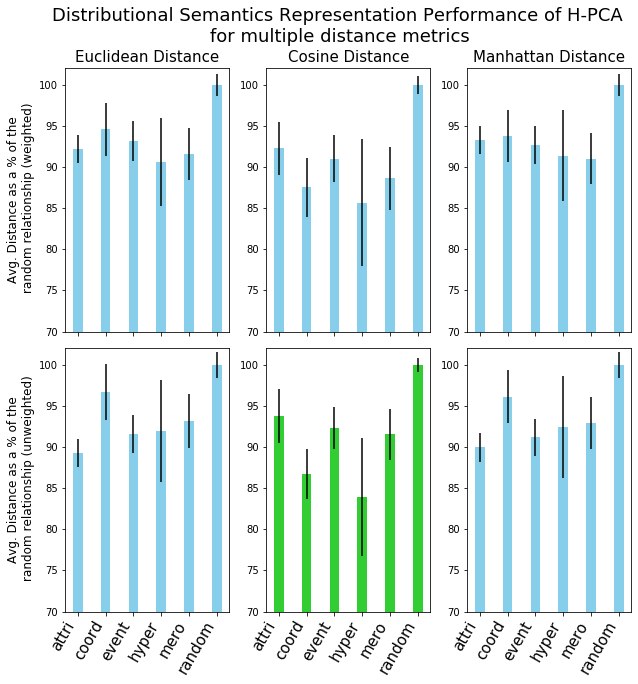

<ipython-input-233-b755c50352f6>:56: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig('../plots/{}_dist_semantics.pdf'.format(title), dpi=None, facecolor='w', edgecolor='w',


In [234]:
plot_barplots('HPCA', distances_dict_percentage, 'H-PCA')

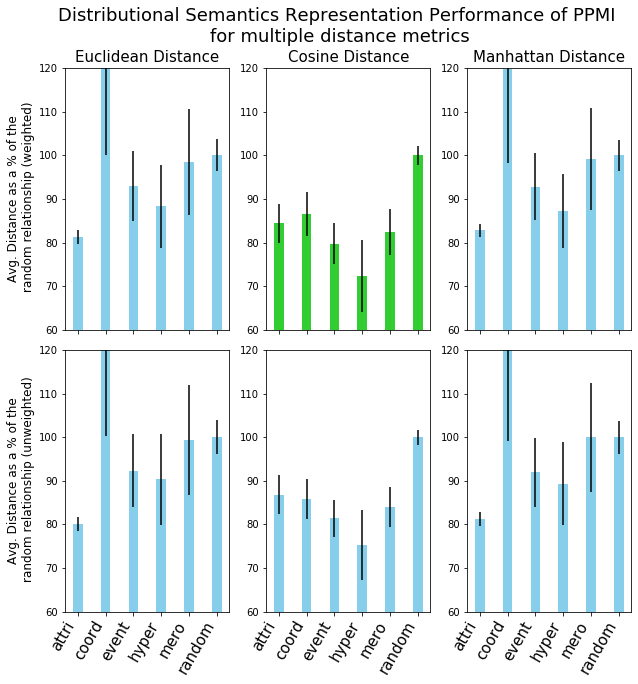

<ipython-input-231-342a2cacf659>:56: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig('../plots/{}_dist_semantics.pdf'.format(title), dpi=None, facecolor='w', edgecolor='w',


In [232]:
plot_barplots('PPMI', distances_dict_percentage, 'PPMI')

## Get Hierarchical Clusters for specific Target Words

In [239]:
def get_word_vectors_n_labels(target_word, data_dictio, word_matrix, category='attri'):
    wids = word_dict_data()
    word_vecs = [get_word_vec(target_word, wids, word_matrix)]
    word_labels = ['TARGET_WORD:'+target_word]
    
    category_words = data_dictio[target_word][category]
    random_words = data_dictio[target_word]['random']
    
    for word in category_words:
        word_vecs.append(get_word_vec(word, wids, word_matrix))
        word_labels.append(category+": "+word)
    
    for rndm_word in random_words:
        word_vecs.append(get_word_vec(rndm_word, wids, word_matrix))
        word_labels.append("random: "+rndm_word)
    
    return np.array(word_vecs), word_labels

def create_cat_dendrogram(cat_vecs, cat_words, category, distance_metric):
    # Create linkage
    link = linkage(cat_vecs, "complete", distance_metric, optimal_ordering=True)

    # Calculate full dendogram
    fig = plt.figure(figsize=(10,25))
    plt.title("Hierarchical Clustering Dendrogram with \n"+category+" and "+distance_metric+" distance metric", fontsize=20)
    plt.xlabel("Distance", fontsize=18)
    plt.ylabel('Class', fontsize=18)
    d = dendrogram(link, labels=cat_words, orientation='right', leaf_rotation=0, leaf_font_size=15)
    plt.show()
    
    fig.savefig('../plots/{}_dendrogram.pdf'.format(category), dpi=None, facecolor='w', edgecolor='w',
    orientation='portrait', papertype=None, format='pdf',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

# H-PCA

## Testing the results obtained by visualizing their behavior on word sets

In [236]:
def organise_data(word_matrix):
    wid_names = word_dict_data()
    wordset_list = stem_words(open('wordest.txt', 'r').read().split('\n'))

    categories = ['animals', 'colors', 'food', 'sports', 'clothing', 'nationalities', 'profanities', 'abbreviations', 'personalities']
    wordset = {category: wordset_list[i*10:(i+1)*10] for i,category in enumerate(categories)}

    # Get final word dictionnary and word labels
    final_word_set = []
    labeled_words = []
    for category in wordset.keys():
        for word in wordset[category]:
            if word in wid_names.keys():
                final_word_set.append(get_word_vec(word, wid_names, word_matrix))
                labeled_word = category+":"+word
                labeled_words.append(labeled_word)
            else:
                pass

    final_word_set = np.array(final_word_set)
    
    return final_word_set, labeled_words

In [237]:
final_word_set, labeled_words = organise_data(H_U_data)

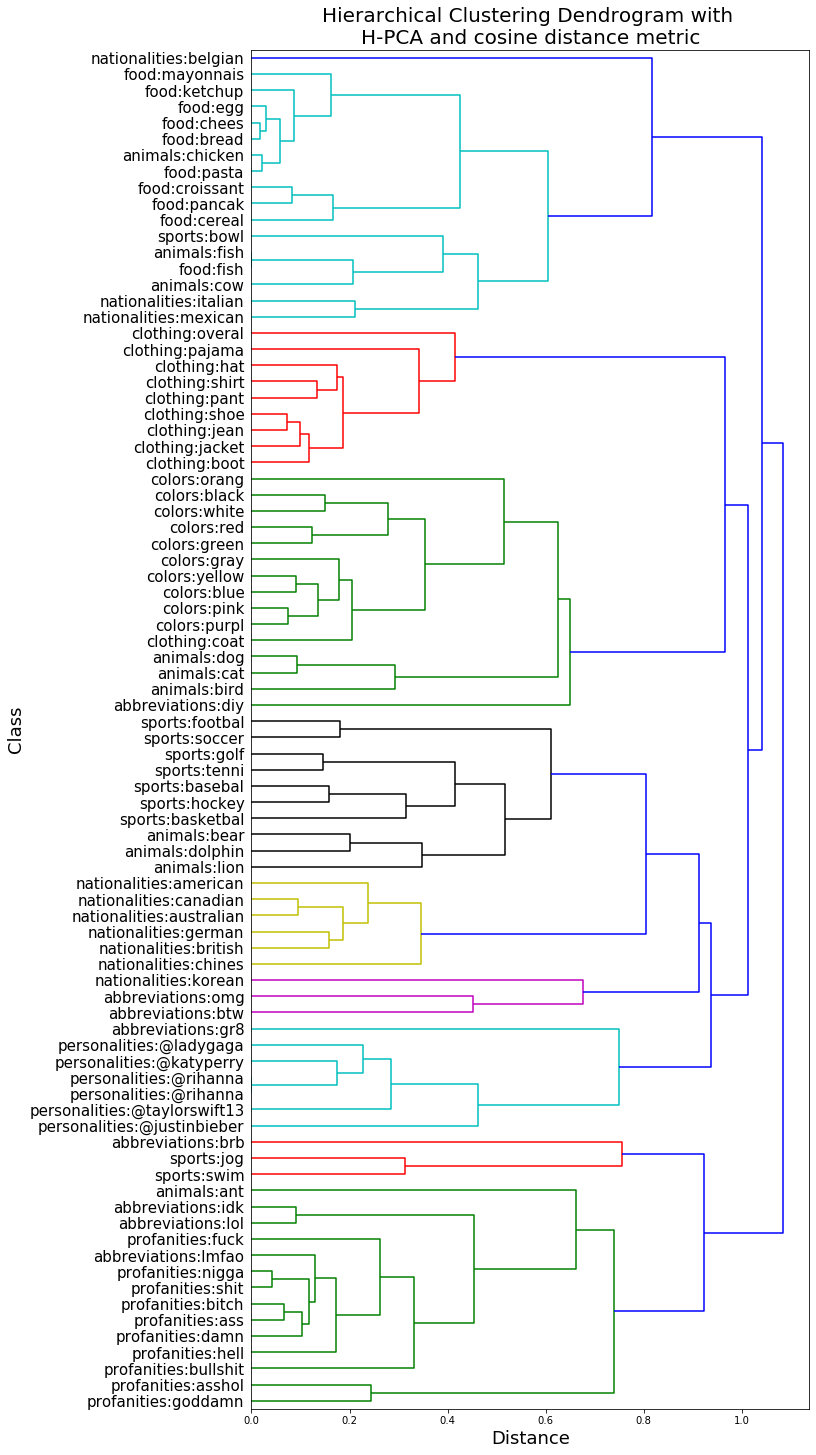

<ipython-input-239-dc245093d912>:31: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig('../plots/{}_dendrogram.pdf'.format(category), dpi=None, facecolor='w', edgecolor='w',


In [247]:
create_cat_dendrogram(final_word_set, labeled_words, "H-PCA", "cosine")

# PPMI

In [241]:
final_word_set, labeled_words = organise_data(PPMI_U_data)

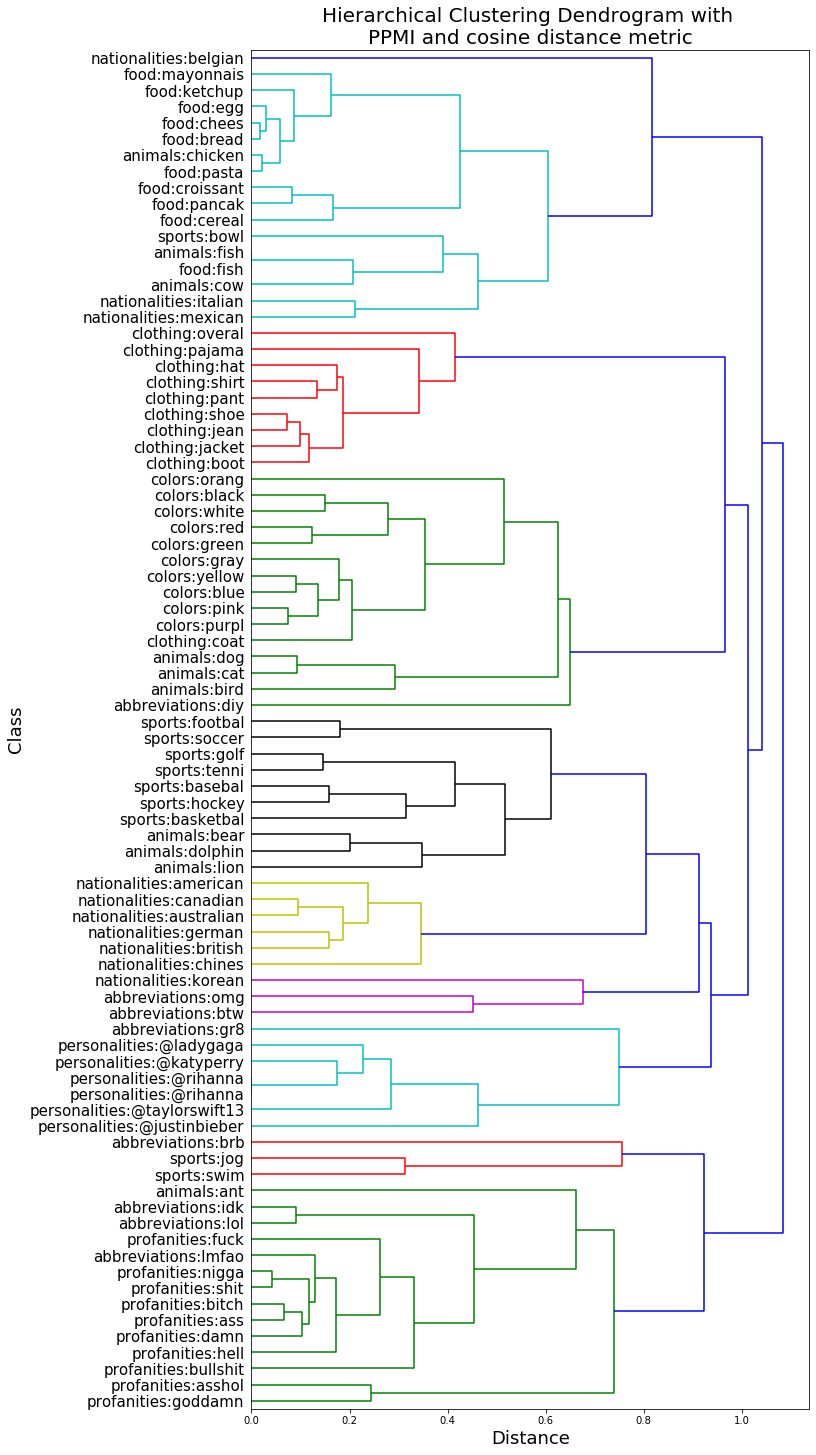

<ipython-input-239-dc245093d912>:31: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig('../plots/{}_dendrogram.pdf'.format(category), dpi=None, facecolor='w', edgecolor='w',


In [242]:
create_cat_dendrogram(final_word_set, labeled_words, "PPMI", "cosine")

## Testing the results obtained by visualizing their behavior on word sets

In [35]:
wordset_list = stem_words(open('wordest.txt', 'r').read().split('\n'))

In [36]:
categories = ['animals', 'colors', 'food', 'sports', 'clothing', 'nationalities', 'profanities', 'abbreviations', 'personalities']
wordset = {category: wordset_list[i*10:(i+1)*10] for i,category in enumerate(categories)}

## Dendrograms of all target words - Euclidean Distance

In [1]:
target_words = list(data_dict.keys())
for target_word in target_words:
    cat_vecs, cat_words = get_word_vectors_n_labels(target_word, data_dict, H_U_data)
    create_cat_dendrogram(cat_vecs, cat_words, 'attribute', 'euclidean')

NameError: name 'data_dict' is not defined

In [2]:
for target_word in target_words:
    cat_vecs, cat_words = get_word_vectors_n_labels(target_word, data_dict, H_U_data, 'hyper')
    create_cat_dendrogram(cat_vecs, cat_words, 'hypernym', 'euclidean')

NameError: name 'target_words' is not defined

## Dendrograms of all target words - Cosine Distance

In [3]:
target_words = list(data_dict.keys())
for target_word in target_words:
    cat_vecs, cat_words = get_word_vectors_n_labels(target_word, data_dict, H_U_data, 'hyper')
    create_cat_dendrogram(cat_vecs, cat_words, 'hypernym', 'cosine')

NameError: name 'data_dict' is not defined

In [4]:
for target_word in target_words:
    cat_vecs, cat_words = get_word_vectors_n_labels(target_word, data_dict, H_U_data, 'coord')
    create_cat_dendrogram(cat_vecs, cat_words, 'coord', 'cosine')

NameError: name 'target_words' is not defined

In [5]:
for target_word in target_words:
    cat_vecs, cat_words = get_word_vectors_n_labels(target_word, data_dict, H_U_data, 'attri')
    create_cat_dendrogram(cat_vecs, cat_words, 'attri', 'cosine')

NameError: name 'target_words' is not defined

# PPMI

## Dendrograms of all target words - Euclidean Distance

In [6]:
target_words = list(data_dict.keys())
for target_word in target_words:
    cat_vecs, cat_words = get_word_vectors_n_labels(target_word, data_dict, PPMI_U_data)
    create_cat_dendrogram(cat_vecs, cat_words, 'attribute', 'euclidean')

NameError: name 'data_dict' is not defined

In [ ]:
for target_word in target_words:
    cat_vecs, cat_words = get_word_vectors_n_labels(target_word, data_dict, PPMI_U_data, 'hyper')
    create_cat_dendrogram(cat_vecs, cat_words, 'hypernym', 'euclidean')

## Dendrograms of all target words - Cosine Distance

In [ ]:
target_words = list(data_dict.keys())
for target_word in target_words:
    cat_vecs, cat_words = get_word_vectors_n_labels(target_word, data_dict, PPMI_U_data, 'hyper')
    create_cat_dendrogram(cat_vecs, cat_words, 'hypernym', 'cosine')

In [ ]:
for target_word in target_words:
    cat_vecs, cat_words = get_word_vectors_n_labels(target_word, data_dict, PPMI_U_data, 'coord')
    create_cat_dendrogram(cat_vecs, cat_words, 'coord', 'cosine')

In [ ]:
for target_word in target_words:
    cat_vecs, cat_words = get_word_vectors_n_labels(target_word, data_dict, PPMI_U_data, 'attri')
    create_cat_dendrogram(cat_vecs, cat_words, 'attri', 'cosine')